<a href="https://colab.research.google.com/github/lxhwww/machine-learning-for-covid-19/blob/main/ex2_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import&data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from statistics import median, mean
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
from sklearn.impute import SimpleImputer 
from sklearn import svm
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from imblearn.ensemble import BalancedBaggingClassifier, RUSBoostClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold
import seaborn as sns
import warnings
from pylab import rcParams
from scipy.stats import f_oneway
from scipy.stats import ttest_ind
from collections import Counter
from keras.utils import np_utils

In [ ]:
transcriptomics=pd.read_csv('/content/drive/MyDrive/single_transcriptomics.csv',low_memory=False)
transcriptomics.head(20)
transcriptomics.shape
transcriptomics=transcriptomics.iloc[:,2:]
transcriptomics
X_trans=transcriptomics.values
print(X_trans.shape)
print(transcriptomics.columns)
col_trans=transcriptomics.columns.tolist()

(100, 13263)
Index(['A1BG', 'A2M', 'AAAS', 'AACS', 'AAGAB', 'AAK1', 'AAMDC', 'AAMP',
       'AANAT', 'AAR2',
       ...
       'ZWILCH', 'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYG11B', 'ZYX',
       'ZZEF1', 'ZZZ3'],
      dtype='object', length=13263)


In [ ]:
proteomics=pd.read_csv('/content/drive/MyDrive/single_proteomics.csv',low_memory=False)
proteomics.head(20)
proteomics.shape
proteomics=proteomics.iloc[:,2:]
proteomics
X_pro=proteomics.values
print(X_pro.shape)
col_pro=proteomics.columns.tolist()

(100, 517)


In [ ]:
metabolomics=pd.read_csv('/content/drive/MyDrive/single_metabolomics.csv')
metabolomics.head(20)

metabolomics=metabolomics.iloc[:,2:]
print(metabolomics.shape)
t=0
for i in metabolomics.columns:
  if not i.find('unknown'):
    t+=1
    metabolomics.drop(columns=i,axis=1,inplace=True)
print(t)
print(metabolomics.shape)
metabolomics.to_csv('single_metabolomics_del.csv')

X_meta=metabolomics.values
print(X_meta.shape)
col_meta=metabolomics.columns.tolist()

(100, 150)
45
(100, 105)
(100, 105)


In [ ]:
lipidomics=pd.read_csv('/content/drive/MyDrive/single_lipidomics.csv',low_memory=False)
lipidomics.head(20)
lipidomics.shape
lipidomics=lipidomics.iloc[:,2:]
print(lipidomics.shape)
t=0
for i in lipidomics.columns:
  if not i.find('Unknown'):
    t+=1
    lipidomics.drop(columns=i,axis=1,inplace=True)
print(t)
print(lipidomics.shape)
lipidomics
X_lip=lipidomics.values
print(X_lip.shape)
col_lip=lipidomics.columns.tolist()


(100, 3357)
2710
(100, 647)
(100, 647)


In [ ]:
file_severity=pd.concat([transcriptomics,proteomics,metabolomics,lipidomics], axis=1)

file_severity.head(20)
file_severity.shape
X=file_severity.values
X.shape

(100, 14532)

In [ ]:
file_info=pd.read_csv('/content/drive/MyDrive/info.csv')
file_info.head
HDF45=pd.DataFrame(np.asarray(file_info.loc[:99,'Hospital_free_days_45']))
HDF45.columns=['Hospital_free_days_45']  
HDF45

,Hospital_free_days_45
0,0
1,39
2,18
3,39
4,27
...,...
95,0
96,35
97,37
98,0


# Feature engineering--autoencoder/corr/ElasticNet



In [ ]:
#select data
X_in=X

In [ ]:
import keras
import matplotlib.pyplot as plt
from keras import regularizers,optimizers
from keras.layers import Dropout

encoding_dim = 500

num=X_in.shape[1]

encoder = keras.models.Sequential([
    keras.layers.Dense(num, activation='relu',kernel_regularizer=regularizers.l1(0.001)),
    keras.layers.Dense(2000, activation='relu',kernel_regularizer=regularizers.l1(0.001)),
    Dropout(0.2),
    keras.layers.Dense(encoding_dim)
])

decoder = keras.models.Sequential([
    Dropout(0.2),                               
    keras.layers.Dense(2000, activation='relu',kernel_regularizer=regularizers.l1(0.001)),
    keras.layers.Dense(num, activation='tanh',activity_regularizer=regularizers.l1_l2(0.0001)),
])

AutoEncoder = keras.models.Sequential([
    encoder,
    decoder,
])
adam=keras.optimizers.adam_v2.Adam(lr=0.001)
AutoEncoder.compile(optimizer=adam, loss='binary_crossentropy')
AutoEncoder.fit(X_in,X_in,epochs=20)

predict = encoder.predict(X_in)
predict.shape

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


4/4 [==============================] - 4s 112ms/step - loss: 1801.2406
Epoch 2/20
4/4 [==============================] - 0s 110ms/step - loss: 1395.3817
Epoch 3/20
4/4 [==============================] - 0s 110ms/step - loss: 1139.2311
Epoch 4/20
4/4 [==============================] - 0s 110ms/step - loss: 1000.9937
Epoch 5/20
4/4 [==============================] - 0s 110ms/step - loss: 939.1041
Epoch 6/20
4/4 [==============================] - 0s 110ms/step - loss: 854.5663
Epoch 7/20
4/4 [==============================] - 0s 109ms/step - loss: 765.7433
Epoch 8/20
4/4 [==============================] - 0s 110ms/step - loss: 700.0466
Epoch 9/20
4/4 [==============================] - 0s 109ms/step - loss: 635.4760
Epoch 10/20
4/4 [==============================] - 0s 110ms/step - loss: 580.1848
Epoch 11/20
4/4 [==============================] - 0s 111ms/step - loss: 529.9896
Epoch 12/20
4/4 [==============================] - 0s 109ms/step - loss: 483.9711
Epoch 13/20
4/4 [===============

(100, 500)

In [ ]:
bottleneck_data=pd.DataFrame(predict)
file_corr=pd.concat([bottleneck_data,HDF45],axis=1)
file_corr.shape

(100, 501)

In [ ]:
from scipy.stats import kendalltau 
p=[]
file_pvalue=file_corr.copy()
for i in file_corr.columns:
  tau,p_value=kendalltau(file_corr[i],file_corr['Hospital_free_days_45'])
  p.append(p_value)
  if p_value>0.05:
    file_pvalue.drop([i],axis=1,inplace=True)
file_pvalue.drop(['Hospital_free_days_45'],axis=1,inplace=True)
print(np.sum(abs(np.asarray(p))<0.05))
file_pvalue.shape
X_p=file_pvalue.values
print(X_p.shape)

496
(100, 495)


In [ ]:
import numpy as np
from sklearn import linear_model

x_data=X_p
y_data=np.asarray(HDF45)
model=linear_model.ElasticNet(max_iter=100000,tol=1e-2,l1_ratio=0.5)
model.fit(x_data,y_data)
#print(model.alpha)
#print(model.coef_)
print(model.n_iter_)
print(np.sum(abs(np.asarray(model.coef_))>0))

100000
106


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.068e+02, tolerance: 2.736e+02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


In [ ]:
print(model.coef_.shape)
print(X_p.T.shape)
X_EN=[]
for i in range(len(X_p.T)):
  if abs(model.coef_[i])>0:
    X_EN.append(X_p.T[i])
print(np.asarray(X_EN).shape)
X_EN=np.asarray(X_EN).T
print(np.asarray(X_EN).shape)

(495,)
(495, 100)
(106, 100)
(100, 106)


# Feature engineering 2-PCA

In [ ]:
#feature extraction PCA,for severity
from sklearn.decomposition import PCA  
from pandas.core.frame import DataFrame

pca_sk = PCA(n_components=40)
PCA_res = pca_sk.fit_transform(X_in)  

PCA_res = DataFrame(PCA_res)
PCA_res.head(10)
PCA_res.shape

# CLustering

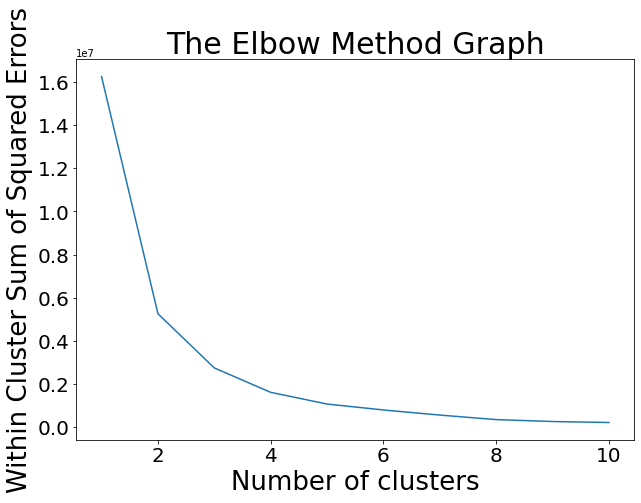

In [ ]:
from sklearn.cluster import KMeans
sse = []
kmax = 10
X=X_EN
for i in range(1,kmax+1): 
    kmeans = KMeans(n_clusters=i, init ='k-means++', max_iter=2000, n_init=10,random_state=40 )
    kmeans.fit(X)
    centroids = kmeans.cluster_centers_
    pred_clusters = kmeans.predict(X)
    curr_sse = 0
    # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
    for i in range(len(X)):
        curr_center = np.array(centroids[pred_clusters[i]])
        curr_point = X[i]
        curr_sse += sum((curr_point-curr_center)**2)     
    sse.append(curr_sse)

plt.figure(figsize=(10,7))     
plt.xticks(fontsize= 20)
plt.yticks(fontsize= 20)
plt.plot(range(1,kmax+1),sse)
plt.title('The Elbow Method Graph',fontsize= 30)
plt.xlabel('Number of clusters',fontsize= 26)
plt.ylabel('Within Cluster Sum of Squared Errors',fontsize= 26)
plt.savefig("elbow.pdf")
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=2, init ='k-means++', max_iter=2000, n_init=10,random_state=40 )
kmeans.fit(X_EN)
centroids = kmeans.cluster_centers_
pred_clusters = kmeans.predict(X_EN)
y=pred_clusters
print(y)

[0 1 0 0 1 1 0 1 0 1 0 1 0 1 1 0 1 0 0 1 1 1 0 1 0 1 1 1 0 0 1 1 0 0 1 0 1
 0 1 1 1 1 1 0 1 1 0 1 0 1 1 0 0 1 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 1 0
 1 1 0 0 1 1 0 1 0 0 0 1 1 1 1 0 0 0 1 0 0 1 0 1 0 0]


In [ ]:
file_info=pd.read_csv('/content/drive/MyDrive/info.csv')
file_info.head
file_info_label=file_info.iloc[:100,:].copy()
print(file_info_label.shape)

df = pd.DataFrame(columns=['label'])
for i in y:
  df = df.append({'label': i}, ignore_index=True)

file_info_label=pd.concat([file_info_label,df], axis=1)

file_info_label.to_csv('file_info_label.csv')

(100, 32)


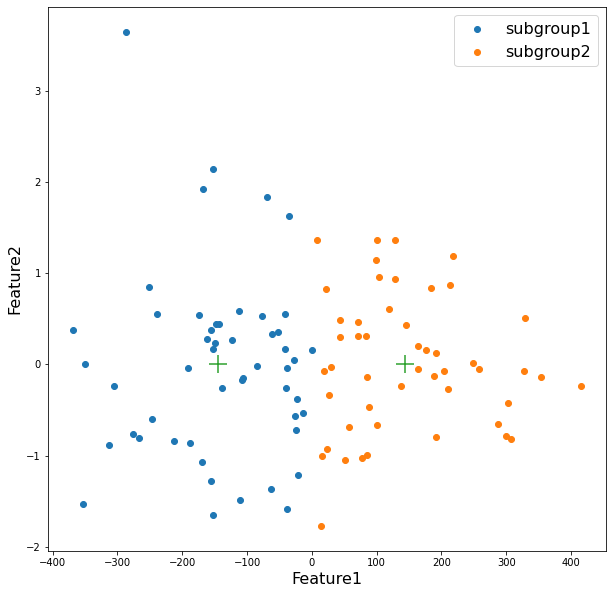

In [ ]:
from sklearn.decomposition import PCA  
pca_sk = PCA(n_components=2)
X_cluster2 = pca_sk.fit_transform(X_EN) 
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))  # 设置画布
# 绘制每个类别的散点图
x1=[]
x2=[]
for i in range(len(y)):
  if y[i]==0:
    x1.append(X_cluster2[i])
  else:
    x2.append(X_cluster2[i])

x1=np.asarray(x1)
x2=np.asarray(x2)

plt.scatter(x1[:][:,0],x1[:][:,1], label='0')
plt.scatter(x2[:][:,0],x2[:][:,1], label='1')
# 绘制聚类中心

pca_sk = PCA(n_components=2)
X_cluster3 = pca_sk.fit_transform(centroids)  
plt.scatter(X_cluster3[:, 0],X_cluster3[:, 1], marker="+", s=300)
plt.xlabel('Feature1',fontsize=16)
plt.ylabel('Feature2',fontsize=16)
plt.legend(['subgroup1','subgroup2'],fontsize=16)
plt.savefig('clusters.pdf')  # 生成图例
plt.show()

# ANOVA


In [ ]:
ytest=[]
for h in HDF45_ls:
  if h<=26:
    ytest.append('a')
  else:
    ytest.append('b')
print(ytest)
ytest=np.asarray(ytest)

NameError: ignored

In [ ]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.datasets import load_iris
from sklearn import preprocessing
#iris = load_iris()
#print(VarianceThreshold(threshold=3).fit_transform(iris.data))
X=X_lip
print(X[0:5])
min_max_scaler = preprocessing.MinMaxScaler()
X_t = min_max_scaler.fit_transform(X.T)
X=X_t.T
print(X[0:5])
selector = VarianceThreshold(threshold=0.0).fit(X,y)
data = selector.transform(X)
print(data.shape)
print(selector.variances_.shape)

aov={}

for i in range(X.shape[1]):
  if selector.variances_[i]>=0.0:
    aov[col_lip[i]]=selector.variances_[i]

print(aov)
aov_sorted=sorted(aov.items(),reverse=True,key=lambda x:x[1])
print(aov_sorted)
print(len(aov_sorted))

[[17.86263344 16.1374984  19.45333113 ... 15.78081765 16.40192482
  17.99641482]
 [20.02304572 18.11433143 21.41475697 ... 14.58193992 15.47439188
  16.87187779]
 [18.9997208  15.84573901 20.77628433 ... 15.37434889 17.28958753
  19.71213626]
 [18.34751921 18.45835703 20.04583399 ... 17.03058936 17.89068767
  20.16605469]
 [19.66763519 18.00286615 21.50637675 ... 17.41859495 17.96617754
  19.89913467]]
[[0.41220511 0.32230953 0.49509526 ... 0.30372314 0.3360886  0.41917637]
 [0.56671812 0.47778616 0.63156156 ... 0.31320286 0.35478452 0.41989702]
 [0.47917348 0.30623254 0.57658703 ... 0.28038501 0.38540247 0.51823706]
 [0.37426484 0.38074869 0.4736137  ... 0.29722644 0.34754089 0.48064642]
 [0.48399746 0.39106252 0.58664435 ... 0.35844585 0.38901439 0.49692081]]
(100, 647)
(647,)
{'AC 2:0_RT_1.273': 0.005757951476010712, 'AC 3:0_RT_1.408': 0.004892536771047553, 'AC 2:0_RT_1.413': 0.006616501120837611, 'AC 5:0_RT_2.381': 0.005570828787933604, 'AC 6:0_RT_4.344': 0.008888416191665919, 'Azi

In [ ]:
aov_sorted_top=aov_sorted[:20]
aov_sorted_top=np.asarray(aov_sorted_top)
aov_sorted_top_v=aov_sorted_top[:,1]
aov_sorted_top_v=aov_sorted_top_v.astype(np.float)
aov_sorted_top_v


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


array([0.0233192 , 0.02105163, 0.02063033, 0.02057246, 0.02024318,
       0.01637741, 0.01518993, 0.01501424, 0.01399962, 0.01339841,
       0.01327642, 0.01287757, 0.01196179, 0.01127446, 0.01117231,
       0.01107901, 0.00939691, 0.00859676, 0.00850303, 0.00708836])

In [ ]:
temp=aov_sorted_top[:,0][::-1]
tt=[]
for i in temp:
  tt.append(i[:12])
print(temp)
print(tt)
tt=np.asarray(tt)
print(tt.shape)
print(aov_sorted_top[:,0][::-1])

['L-Proline, 2TMS derivative RT9.926992'
 'Quinolinic acid, bis(trimethylsilyl) ester RT14.717184'
 '2,3-Dihydroxybutanoic acid, tris(trimethylsilyl)- RT10.455827'
 'Sugar RT14.882448' 'Sugar RT15.948677'
 '3-Hydroxybutyric acid, 2TMS derivative RT8.103591' 'Sugar RT16.115755'
 'Sugar acid RT17.285215'
 'Phosphorylethanolamine, 4TMS derivative RT15.271004'
 'Indol-5-ol, 2TMS derivative RT14.572634'
 'Hydroxybenzeneacetic acid, 2TMS derivative RT13.857543'
 'Methylphenol RT8.024749' 'Naproxen, TMS derivative RT18.090047'
 'Sugar RT19.222404' 'Sugar RT14.499155' 'Sugar RT17.885434'
 'Sugar RT16.657726' 'Salicylic acid' 'Sugar RT16.206201'
 'Sugar RT22.861927']
['L-Proline, 2', 'Quinolinic a', '2,3-Dihydrox', 'Sugar RT14.8', 'Sugar RT15.9', '3-Hydroxybut', 'Sugar RT16.1', 'Sugar acid R', 'Phosphorylet', 'Indol-5-ol, ', 'Hydroxybenze', 'Methylphenol', 'Naproxen, TM', 'Sugar RT19.2', 'Sugar RT14.4', 'Sugar RT17.8', 'Sugar RT16.6', 'Salicylic ac', 'Sugar RT16.2', 'Sugar RT22.8']
(20,)
['L-Pr

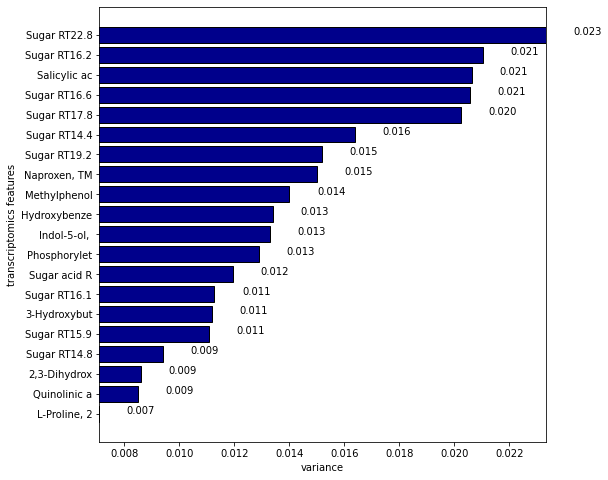

In [ ]:
plt.figure(figsize=(8,8))

plt.barh(tt, aov_sorted_top_v[::-1], color='darkblue', edgecolor='black')
plt.xlabel('variance') # x 轴
plt.xlim(min(aov_sorted_top_v[::-1]),max(aov_sorted_top_v[::-1]))
plt.ylabel('transcriptomics features') # y轴
#plt.title('Feature Importances') # 标题
for a,b in zip( aov_sorted_top_v[::-1],tt): # 添加数字标签
   plt.text(a+0.001, b,'%.3f'%float(a)) # a+0.001代表标签位置在柱形图上方0.001处

plt.savefig("aovMeta.pdf",dpi=200,bbox_inches='tight')
plt.show()


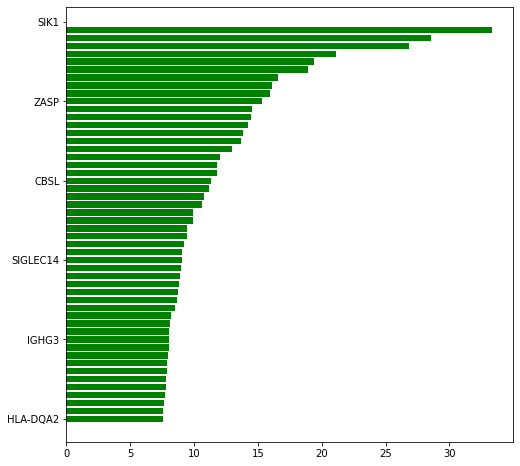

In [ ]:
AAAfig, ax = plt.subplots(figsize=(8,8))# 函数用于创建子图
people =aov_sorted_top[:,0][::-1]
y_pos = np.arange(len(people))
performance = aov_sorted_top_v[::-1]

ax.barh(y_pos, performance,color = "green",)
ax.set_yticks(y_pos)
ax.set_yticklabels(people)# 设置y轴坐标属性值

plt.show()


# Obtain Cluster Classification Label and Training Model

In [ ]:
a=[]
b=[]
HDF45_ls=HDF45['Hospital_free_days_45'].tolist() 
for i in range(len(pred_clusters)):
  if pred_clusters[i]==1:
    a.append(HDF45_ls[i])
  else:
    b.append(HDF45_ls[i])
print(len(a))
print(len(b))
print(np.asarray(a).mean())
print(np.asarray(b).mean())

51
49
20.019607843137255
24.244897959183675


In [ ]:
Cn=4950
count=0
n=len(a)*len(b)
for i in a:
  for j in b:
    if i<=j:
      count+=1
print(count)
print(count/Cn)
print(count/n)

1600
0.32323232323232326
0.6402561024409764


In [ ]:
import pandas as pd
from datetime import datetime
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from numpy import concatenate
from math import sqrt

train_x,test_x,train_y,test_y = train_test_split(X_EN,y,test_size=0.2,shuffle=True)
print(train_x.shape)
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))

model = Sequential()
model.add(LSTM(50, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network

history = model.fit(train_x, train_y, epochs=50, batch_size=72,validation_data=(test_x, test_y),verbose=2, shuffle=False)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

#scaler = MinMaxScaler(feature_range=(0, 1))

yhat = model.predict(test_x)
test_x= test_x.reshape((test_x.shape[0], test_x.shape[2]))
inv_yhat = concatenate((yhat, test_x[:, 1:]), axis=1)
#inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
#inv_y = scaler.inverse_transform(test_x)
test_x = test_x[:,0]
rmse = sqrt(mean_squared_error(test_x, inv_yhat))
print('Test RMSE: %.3f' % rmse)

  

ValueError: ignored

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
 
auc=[]
accu=[]
f1=[]

input_shape=X_EN.shape[1]
model = Sequential()
model.add(Dense(128, input_dim=input_shape, activation='sigmoid'))
model.add(Dense(64, activation='sigmoid'))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1,activation='softmax'))


model.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

train_x,test_x,train_y,test_y = train_test_split(X_EN,y,test_size=0.2,shuffle=True)
oversample=SMOTE()
train_x,train_y=oversample.fit_resample(train_x, train_y)
model.fit(train_x,train_y,epochs=10,batch_size=10,verbose=1)
y_pred=model.predict(test_x,batch_size=10)
score=model.evaluate(test_x,test_y, batch_size=20)


print("MLP")
auc.append(score[1])
print('accuracy',auc)

f1=f1_score(test_y,y_pred)
print('f1',f1)

auc=roc_auc_score(test_y,y_pred)
print(auc)

Epoch 1/10
9/9 [==============================] - 1s 4ms/step - loss: 0.7126 - accuracy: 0.5000
Epoch 2/10
9/9 [==============================] - 0s 4ms/step - loss: 0.7058 - accuracy: 0.5000
Epoch 3/10
9/9 [==============================] - 0s 4ms/step - loss: 0.6985 - accuracy: 0.5000
Epoch 4/10
9/9 [==============================] - 0s 3ms/step - loss: 0.7007 - accuracy: 0.5000
Epoch 5/10
9/9 [==============================] - 0s 4ms/step - loss: 0.6992 - accuracy: 0.5000
Epoch 6/10
9/9 [==============================] - 0s 4ms/step - loss: 0.6993 - accuracy: 0.5000
Epoch 7/10
9/9 [==============================] - 0s 3ms/step - loss: 0.7023 - accuracy: 0.5000
Epoch 8/10
9/9 [==============================] - 0s 4ms/step - loss: 0.6946 - accuracy: 0.5000
Epoch 9/10
9/9 [==============================] - 0s 4ms/step - loss: 0.7007 - accuracy: 0.5000
Epoch 10/10
1/1 [==============================] - 0s 153ms/step - loss: 0.6932 - accuracy: 0.5000
MLP
accuracy [0.5]
f1 0.6666666666666

In [ ]:
X_EN,y
train_x=X_EN[:60]
test_x=X_EN[60:]
train_y=y[:60]
test_y=y[60:]
clf = RandomForestClassifier().fit(train_x, train_y)
predicted=clf.predict(test_x)

In [ ]:
a=[]
b=[]
for i in range(0,40):
  if predicted[i]==1:
    a.append(HDF45[i+60])
  else:
    b.append(HDF45[i+60])
print(len(a))
print(len(b))
print(np.asarray(a).mean())
print(np.asarray(b).mean())


count=0
n=len(a)*len(b)
for i in a:
  for j in b:
    if i<=j:
      count+=1
print(count)
print(count/n)


22
18
21.545454545454547
25.72222222222222
244
0.6161616161616161


In [ ]:
#Models for training
def svm_model(X, y, sf, prediction_dict):
	auc=[]
	accu=[]
	f1=[]
	for train_ix , test_ix in sf.split(X, y):
		train_x, test_x = X[train_ix], X[test_ix]
		train_y,test_y = np.array(y)[train_ix],np.array(y)[test_ix]
		clf=svm.SVC()
		oversample=SMOTE()
		train_x,train_y=oversample.fit_resample(train_x, train_y)
		clf.fit(train_x, train_y)
	
		####predict_train=clf.predict(train_x)
		predicted=clf.predict(test_x)
		auc.append(roc_auc_score(test_y, predicted))
		accu.append(accuracy_score(test_y, predicted))
		f1.append(f1_score(test_y,predicted))
	auc=mean(auc)
	accu=mean(accu)
	f1=mean(f1)
	prediction_dict["SVM"]=[auc, accu, f1 ]
	return prediction_dict

def RandomForest_model(X, y, sf, prediction_dict):
	auc=[]
	accu=[]
	f1=[]
	for train_ix , test_ix in sf.split(X, y):
		train_x, test_x = X[train_ix], X[test_ix]
		train_y,test_y = np.array(y)[train_ix],np.array(y)[test_ix]
		oversample=SMOTE()
		train_x,train_y=oversample.fit_resample(train_x, train_y)
		clf = RandomForestClassifier().fit(train_x, train_y)
		predicted=clf.predict(test_x)
		auc.append(roc_auc_score(test_y, predicted))
		accu.append(accuracy_score(test_y, predicted))
		f1.append(f1_score(test_y,predicted))
	auc=mean(auc)
	accu=mean(accu)
	f1=mean(f1)
	prediction_dict["RandomForest"]=[auc, accu, f1 ]
	return prediction_dict

def Logistic_model(X, y, sf,prediction_dict):

	auc=[]
	accu=[]
	f1=[]
	for train_ix , test_ix in sf.split(X, y):
		train_x, test_x = X[train_ix], X[test_ix]
		train_y,test_y = np.array(y)[train_ix],np.array(y)[test_ix]
		oversample=SMOTE()
		train_x,train_y=oversample.fit_resample(train_x, train_y)
		clf = LogisticRegression().fit(train_x, train_y)
		predicted=clf.predict(test_x)
		auc.append(roc_auc_score(test_y, predicted))
		accu.append(accuracy_score(test_y, predicted))
		f1.append(f1_score(test_y,predicted))
	auc=mean(auc)
	accu=mean(accu)
	f1=mean(f1)
	prediction_dict["Logistic Regression"]=[auc, accu, f1 ]
	return prediction_dict
def Knearest_model(X, y, sf ,prediction_dict):

	auc=[]
	accu=[]
	f1=[]
	for train_ix , test_ix in sf.split(X, y):
		train_x, test_x = X[train_ix], X[test_ix]
		train_y,test_y = np.array(y)[train_ix],np.array(y)[test_ix]
		
		oversample=SMOTE()
		train_x,train_y=oversample.fit_resample(train_x, train_y)
		clf = KNeighborsClassifier().fit(train_x, train_y)
		predicted=clf.predict(test_x)
		auc.append(roc_auc_score(test_y, predicted))
		accu.append(accuracy_score(test_y, predicted))
		f1.append(f1_score(test_y,predicted))
	auc=mean(auc)
	accu=mean(accu)
	f1=mean(f1)
	prediction_dict["Knearest Model"]=[ auc, accu, f1 ]
	return prediction_dict

def BalancedBagging_model(X, y,sf,prediction_dict):

	auc=[]
	accu=[]
	f1=[]
	for train_ix , test_ix in sf.split(X, y):
		train_x, test_x = X[train_ix], X[test_ix]
		train_y,test_y = np.array(y)[train_ix],np.array(y)[test_ix]
		oversample=SMOTE()
		train_x,train_y=oversample.fit_resample(train_x, train_y)
		clf = BalancedBaggingClassifier().fit(train_x, train_y)
		predicted=clf.predict(test_x)
		auc.append(roc_auc_score(test_y, predicted))
		accu.append(accuracy_score(test_y, predicted))
		f1.append(f1_score(test_y,predicted))
	auc=mean(auc)
	accu=mean(accu)
	f1=mean(f1)
	prediction_dict["Balanced Bagging"]=[ auc, accu, f1 ]
	return prediction_dict

def RUS_model(X, y, sf ,prediction_dict):

	auc=[]
	accu=[]
	f1=[]
	for train_ix , test_ix in sf.split(X, y):
		train_x, test_x = X[train_ix], X[test_ix]
		train_y,test_y = np.array(y)[train_ix],np.array(y)[test_ix]
		oversample=SMOTE()
		train_x,train_y=oversample.fit_resample(train_x, train_y)
		clf = RUSBoostClassifier().fit(train_x, train_y)
		predicted=clf.predict(test_x)
		auc.append(roc_auc_score(test_y, predicted))
		accu.append(accuracy_score(test_y, predicted))
		f1.append(f1_score(test_y,predicted))
	auc=mean(auc)
	accu=mean(accu)
	f1=mean(f1)
	prediction_dict["RUS"]=[auc, accu, f1 ]
	return prediction_dict

def Training(all_features, all_labels):
	prediction_dict={}
	sf=StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
	prediction_dict=svm_model(all_features, all_labels, sf, prediction_dict)
	prediction_dict=RandomForest_model(all_features, all_labels, sf, prediction_dict)
	prediction_dict=Logistic_model(all_features, all_labels,sf,prediction_dict)
	prediction_dict=Knearest_model(all_features, all_labels, sf, prediction_dict)
	#prediction_dict=BalancedBagging_model(all_features, all_labels,sf, prediction_dict)
	prediction_dict=RUS_model(all_features, all_labels,sf, prediction_dict)

	l=prediction_dict.items()
	maximum=0
	model=""
	for item in l:
		if item[1][2]>maximum:
			maximum=item[1][2]
			model=item[0]
	print( "\n--- Training and Testing Completed ! ---\n")
	print("\n\nSelected Model: "+ model + " F1 score: " + str(maximum))
	return prediction_dict

#把HFD45加到y
scores_dict=Training(X_EN,y)
print(scores_dict)


--- Training and Testing Completed ! ---



Selected Model: RandomForest F1 score: 1.0
{'SVM': [0.98, 0.98, 0.9818181818181818], 'RandomForest': [1.0, 1.0, 1.0], 'Logistic Regression': [0.8266666666666667, 0.8300000000000001, 0.8128860028860029], 'Knearest Model': [0.9775, 0.98, 0.9766233766233766], 'RUS': [1.0, 1.0, 1.0]}


In [ ]:
#Calculate the c-index of K intersection


sf=StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
for train_ix , test_ix in sf.split(X, y):
  train_x, test_x = X[train_ix], X[test_ix]
  train_y,test_y = np.array(y)[train_ix],np.array(y)[test_ix]


